# Physics Video Prediction - Training

Train a transformer-based model to predict physics simulation frames.

**Architecture**: CNN Encoder → Transformer → CNN Decoder

**Goal**: Model learns to compress video to latent state that captures physics (position, velocity, etc.)

In [ ]:
# === COLAB SETUP ===
# Clone repo (run once)
!rm -rf MNIST_AI 2>/dev/null
!git clone https://github.com/Caleb-Briggs/MNIST_AI.git
%cd MNIST_AI/experiments/physics_prediction

# Optional: Mount Google Drive for persistent storage
# Uncomment these lines to save checkpoints to Drive (survives disconnects)
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir -p /content/drive/MyDrive/physics_prediction_results
# !ln -sf /content/drive/MyDrive/physics_prediction_results results

print("Setup complete!")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import HTML
import matplotlib.animation as animation

from physics_sim import (
    Ball, Barrier, PhysicsSimulation,
    generate_trajectory, create_random_simulation, generate_dataset
)
from model import VideoPredictor, count_parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB


## 1. Configuration

In [ ]:
# Data config
NUM_TRAJECTORIES = 5000  # More data for bigger model
FRAMES_PER_TRAJECTORY = 50
NUM_BARRIERS = 3
WITH_GRAVITY = False
DT = 3.0

# Model config (bigger model)
LATENT_DIM = 512  # 256 -> 512
N_HEADS = 8       # 4 -> 8
N_LAYERS = 8      # 4 -> 8
CONTEXT_LEN = 8

# Training config (optimized for A100)
BATCH_SIZE = 256  # Much larger batch - A100 can handle it
LEARNING_RATE = 3e-4  # Scale up LR with batch size
NUM_EPOCHS = 200
SEED = 42

# Checkpointing config
CHECKPOINT_EVERY = 10
VIS_EVERY = 20
LOG_FILE = 'results/training_log.txt'

torch.manual_seed(SEED)
np.random.seed(SEED)

# Enable TF32 for faster matmuls on A100
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

print(f"Model: {LATENT_DIM}d latent, {N_HEADS} heads, {N_LAYERS} layers")
print(f"Training: batch={BATCH_SIZE}, lr={LEARNING_RATE}, epochs={NUM_EPOCHS}")

## 2. Generate Training Data

In [4]:
print("Generating training data...")
data = generate_dataset(
    num_trajectories=NUM_TRAJECTORIES,
    num_frames=FRAMES_PER_TRAJECTORY,
    num_barriers=NUM_BARRIERS,
    with_gravity=WITH_GRAVITY,
    base_seed=SEED,
    dt=DT
)

print(f"Dataset shape: {data.shape}")
print(f"Memory: {data.nbytes / 1024 / 1024:.1f} MB")

# Convert to torch tensor
data_tensor = torch.from_numpy(data).float().unsqueeze(2)  # Add channel dim: (N, T, 1, H, W)
print(f"Tensor shape: {data_tensor.shape}")

Generating training data...
Dataset shape: (1000, 50, 64, 64)
Memory: 781.2 MB
Tensor shape: torch.Size([1000, 50, 1, 64, 64])


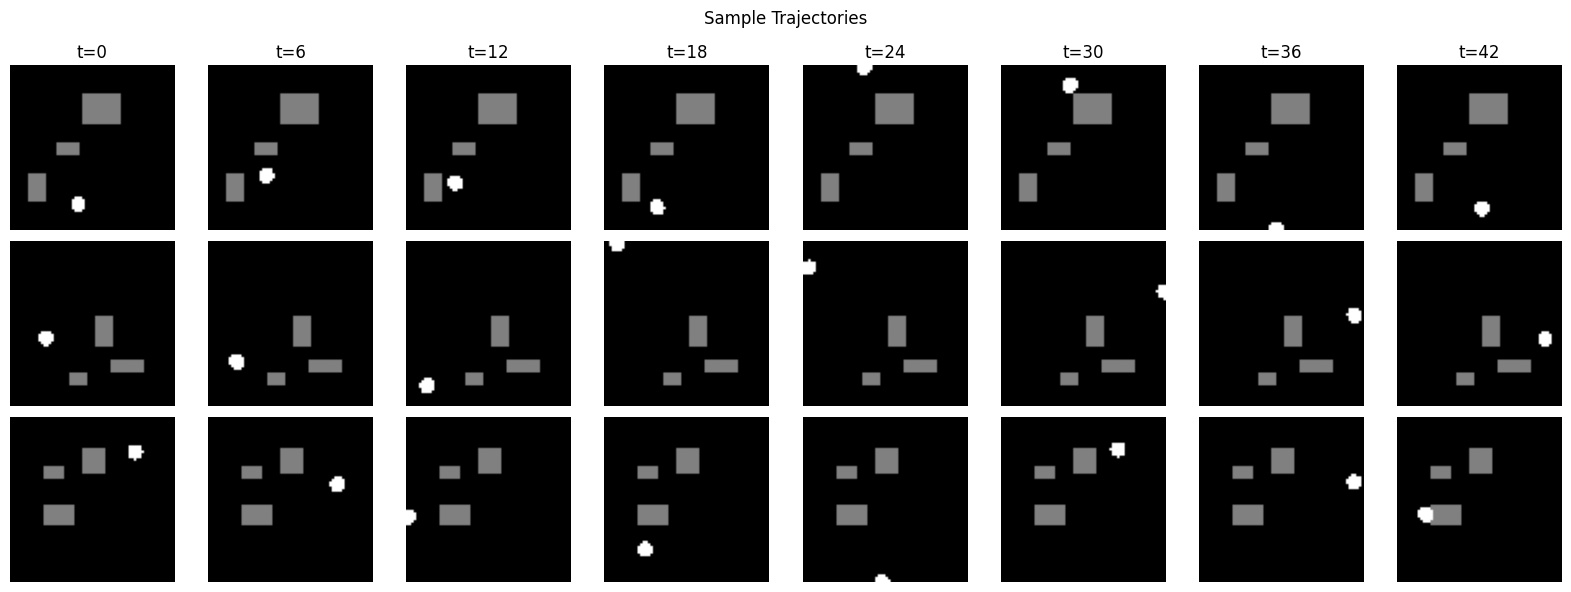

In [5]:
# Visualize a few trajectories
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
for row in range(3):
    for col in range(8):
        t = col * 6  # 0, 6, 12, 18, 24, 30, 36, 42 (fits in 50 frames)
        axes[row, col].imshow(data[row, t], cmap='gray', vmin=0, vmax=1)
        if row == 0:
            axes[row, col].set_title(f't={t}')
        axes[row, col].axis('off')
plt.suptitle('Sample Trajectories')
plt.tight_layout()
plt.show()

## 3. Create Dataset and DataLoader

In [ ]:
class PhysicsDataset(torch.utils.data.Dataset):
    """Simple dataset: fixed context length, predict next frame."""
    
    def __init__(self, trajectories: torch.Tensor, context_len: int):
        self.trajectories = trajectories
        self.context_len = context_len
        self.num_traj = trajectories.size(0)
        self.num_frames = trajectories.size(1)
        self.samples_per_traj = self.num_frames - context_len
        
    def __len__(self):
        return self.num_traj * self.samples_per_traj
    
    def __getitem__(self, idx):
        traj_idx = idx // self.samples_per_traj
        frame_idx = idx % self.samples_per_traj
        
        context = self.trajectories[traj_idx, frame_idx:frame_idx + self.context_len]
        target = self.trajectories[traj_idx, frame_idx + self.context_len]
        
        return context, target


# Split into train/val
train_size = int(0.9 * NUM_TRAJECTORIES)
train_data = data_tensor[:train_size]
val_data = data_tensor[train_size:]

train_dataset = PhysicsDataset(train_data, CONTEXT_LEN)
val_dataset = PhysicsDataset(val_data, CONTEXT_LEN)

# Optimized dataloaders for A100
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

## 4. Create Model

In [7]:
model = VideoPredictor(
    latent_dim=LATENT_DIM,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dim_feedforward=LATENT_DIM * 2,
    dropout=0.1
).to(device)

print(f"Model parameters: {count_parameters(model):,}")

# Test forward pass
sample_context, sample_target = next(iter(train_loader))
sample_context = sample_context.to(device)

with torch.no_grad():
    sample_pred = model(sample_context)

print(f"Context shape: {sample_context.shape}")
print(f"Target shape: {sample_target.shape}")
print(f"Prediction shape: {sample_pred.shape}")

Model parameters: 5,653,697


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Context shape: torch.Size([32, 8, 1, 64, 64])
Target shape: torch.Size([32, 1, 64, 64])
Prediction shape: torch.Size([32, 1, 64, 64])


## 5. Training Loop

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Loss function: MSE on pixels
criterion = nn.MSELoss()

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []
}

# Create results directory
import os
os.makedirs('results', exist_ok=True)

# Helper functions for checkpointing
def save_checkpoint(epoch, model, optimizer, scheduler, history, path):
    """Save training checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history,
        'config': {
            'latent_dim': LATENT_DIM,
            'n_heads': N_HEADS,
            'n_layers': N_LAYERS,
            'context_len': CONTEXT_LEN,
            'dt': DT,
        }
    }
    torch.save(checkpoint, path)

def log_progress(message, log_file=LOG_FILE):
    """Log message to file and print."""
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_message = f"[{timestamp}] {message}"
    print(log_message)
    with open(log_file, 'a') as f:
        f.write(log_message + '\n')

# Clear log file
with open(LOG_FILE, 'w') as f:
    f.write(f"Training started - {NUM_EPOCHS} epochs\n")
    f.write(f"Config: {NUM_TRAJECTORIES} trajectories, dt={DT}, context={CONTEXT_LEN}\n")
    f.write("="*60 + "\n")

In [ ]:
# Use automatic mixed precision for faster training on A100
scaler = torch.cuda.amp.GradScaler()

def train_epoch(model, loader, optimizer, criterion, device, scaler):
    """Train for one epoch with mixed precision."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for context, target in loader:
        context = context.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()
        
        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            pred = model(context)
            loss = criterion(pred, target)
        
        # Scaled backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    """Evaluate for one epoch."""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    for context, target in loader:
        context = context.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        
        with torch.cuda.amp.autocast():
            pred = model(context)
            loss = criterion(pred, target)
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


@torch.no_grad()
def quick_visualize(model, val_data, device, epoch, context_len=8):
    """Quick visualization during training."""
    model.eval()
    
    fig, axes = plt.subplots(3, 5, figsize=(12, 7))
    
    for row in range(3):
        traj_idx = row * 30
        
        context = val_data[traj_idx, :context_len].unsqueeze(0).to(device)
        target = val_data[traj_idx, context_len]
        pred = model(context).cpu().squeeze(0)
        
        axes[row, 0].imshow(context[0, -2, 0].cpu(), cmap='gray', vmin=0, vmax=1)
        axes[row, 0].set_title('Ctx t-1' if row == 0 else '')
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(context[0, -1, 0].cpu(), cmap='gray', vmin=0, vmax=1)
        axes[row, 1].set_title('Ctx t' if row == 0 else '')
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(pred[0].clamp(0, 1), cmap='gray', vmin=0, vmax=1)
        axes[row, 2].set_title('Predicted' if row == 0 else '')
        axes[row, 2].axis('off')
        
        axes[row, 3].imshow(target[0], cmap='gray', vmin=0, vmax=1)
        axes[row, 3].set_title('Ground Truth' if row == 0 else '')
        axes[row, 3].axis('off')
        
        error = torch.abs(pred[0] - target[0])
        axes[row, 4].imshow(error, cmap='hot', vmin=0, vmax=0.5)
        axes[row, 4].set_title('Error' if row == 0 else '')
        axes[row, 4].axis('off')
    
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()

In [ ]:
# Main training loop with checkpointing
log_progress(f"Starting training for {NUM_EPOCHS} epochs...")

best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, scaler)
    val_loss = eval_epoch(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    scheduler.step()
    
    # Log progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        log_progress(f"Epoch {epoch+1:3d}/{NUM_EPOCHS}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")
    
    # Save checkpoint periodically
    if (epoch + 1) % CHECKPOINT_EVERY == 0:
        save_checkpoint(epoch + 1, model, optimizer, scheduler, history, 
                       f'results/checkpoint_epoch_{epoch+1}.pt')
        log_progress(f"Saved checkpoint at epoch {epoch+1}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(epoch + 1, model, optimizer, scheduler, history,
                       'results/best_model.pt')
    
    # Periodic visualization (saves to file instead of displaying)
    if (epoch + 1) % VIS_EVERY == 0:
        quick_visualize(model, val_data, device, epoch + 1, CONTEXT_LEN)
        plt.savefig(f'results/vis_epoch_{epoch+1}.png', dpi=100, bbox_inches='tight')
        plt.close()

# Final save
save_checkpoint(NUM_EPOCHS, model, optimizer, scheduler, history, 'results/final_model.pt')
log_progress(f"Training complete! Best val_loss: {best_val_loss:.6f}")

# Save training curves
import json
with open('results/history.json', 'w') as f:
    json.dump(history, f)

## 6. Visualizations

### Training Curves

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Learning rate
axes[1].plot(history['lr'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Single-Step Predictions vs Ground Truth

In [ ]:
@torch.no_grad()
def visualize_predictions(model, val_data, device, num_samples=5, context_len=8):
    """Show context, prediction, ground truth, and error."""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(12, 2.5*num_samples))
    
    indices = np.random.choice(len(val_data), num_samples, replace=False)
    
    for row, traj_idx in enumerate(indices):
        # Random starting point in trajectory
        start = np.random.randint(0, len(val_data[traj_idx]) - context_len - 1)
        
        context = val_data[traj_idx, start:start+context_len].unsqueeze(0).to(device)
        target = val_data[traj_idx, start+context_len]
        pred = model(context).cpu().squeeze(0)
        
        # Show last 2 context frames
        axes[row, 0].imshow(context[0, -2, 0].cpu(), cmap='gray', vmin=0, vmax=1)
        axes[row, 0].set_title('Ctx t-1' if row == 0 else '')
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(context[0, -1, 0].cpu(), cmap='gray', vmin=0, vmax=1)
        axes[row, 1].set_title('Ctx t' if row == 0 else '')
        axes[row, 1].axis('off')
        
        # Prediction
        axes[row, 2].imshow(pred[0].clamp(0, 1), cmap='gray', vmin=0, vmax=1)
        axes[row, 2].set_title('Predicted' if row == 0 else '')
        axes[row, 2].axis('off')
        
        # Ground truth
        axes[row, 3].imshow(target[0], cmap='gray', vmin=0, vmax=1)
        axes[row, 3].set_title('Ground Truth' if row == 0 else '')
        axes[row, 3].axis('off')
        
        # Error
        error = torch.abs(pred[0] - target[0])
        axes[row, 4].imshow(error, cmap='hot', vmin=0, vmax=0.5)
        axes[row, 4].set_title('Error' if row == 0 else '')
        axes[row, 4].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_data, device, num_samples=5, context_len=CONTEXT_LEN)

### Autoregressive Rollouts

In [ ]:
@torch.no_grad()
def visualize_rollout(model, trajectories, device, traj_idx=0, context_len=8, rollout_steps=20):
    """Compare autoregressive rollout with ground truth."""
    model.eval()
    
    # Get initial context
    context = trajectories[traj_idx, :context_len].unsqueeze(0).to(device)
    
    # Ground truth future
    gt_future = trajectories[traj_idx, context_len:context_len+rollout_steps].cpu().numpy()
    
    # Autoregressive rollout
    predicted = model.rollout(context, rollout_steps).cpu().squeeze(0).numpy()
    
    # Visualize
    num_show = min(8, rollout_steps)
    step_indices = np.linspace(0, rollout_steps-1, num_show, dtype=int)
    
    fig, axes = plt.subplots(3, num_show, figsize=(2*num_show, 6))
    
    for col, t in enumerate(step_indices):
        # Predicted
        axes[0, col].imshow(np.clip(predicted[t, 0], 0, 1), cmap='gray', vmin=0, vmax=1)
        if col == 0:
            axes[0, col].set_ylabel('Predicted')
        axes[0, col].set_title(f't+{t+1}')
        axes[0, col].axis('off')
        
        # Ground truth
        axes[1, col].imshow(gt_future[t, 0], cmap='gray', vmin=0, vmax=1)
        if col == 0:
            axes[1, col].set_ylabel('Ground Truth')
        axes[1, col].axis('off')
        
        # Error
        error = np.abs(np.clip(predicted[t, 0], 0, 1) - gt_future[t, 0])
        axes[2, col].imshow(error, cmap='hot', vmin=0, vmax=0.5)
        if col == 0:
            axes[2, col].set_ylabel('Error')
        axes[2, col].axis('off')
    
    plt.suptitle(f'Autoregressive Rollout ({rollout_steps} steps)')
    plt.tight_layout()
    plt.show()
    
    # Compute MSE over time
    mse_over_time = np.mean((np.clip(predicted[:, 0], 0, 1) - gt_future[:, 0])**2, axis=(1, 2))
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, rollout_steps+1), mse_over_time)
    plt.xlabel('Rollout Step')
    plt.ylabel('MSE')
    plt.title('Prediction Error vs Rollout Length')
    plt.grid(alpha=0.3)
    plt.show()

# Test rollout
for traj_idx in [0, 30, 60]:
    print(f"\nTrajectory {traj_idx}:")
    visualize_rollout(model, val_data, device, traj_idx=traj_idx, context_len=CONTEXT_LEN, rollout_steps=20)

### Animated Comparison

In [ ]:
@torch.no_grad()
def animate_rollout_comparison(model, trajectories, device, traj_idx=0, context_len=8, rollout_steps=30):
    """Create side-by-side animation of prediction vs ground truth."""
    model.eval()
    
    # Get data
    context = trajectories[traj_idx, :context_len].unsqueeze(0).to(device)
    gt_future = trajectories[traj_idx, context_len:context_len+rollout_steps].cpu().numpy()
    predicted = model.rollout(context, rollout_steps).cpu().squeeze(0).numpy()
    
    # Create animation
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    im_pred = axes[0].imshow(np.clip(predicted[0, 0], 0, 1), cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Predicted')
    axes[0].axis('off')
    
    im_gt = axes[1].imshow(gt_future[0, 0], cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    error = np.abs(np.clip(predicted[0, 0], 0, 1) - gt_future[0, 0])
    im_err = axes[2].imshow(error, cmap='hot', vmin=0, vmax=0.5)
    axes[2].set_title('Error')
    axes[2].axis('off')
    
    title = fig.suptitle('t+1')
    
    def update(frame):
        im_pred.set_array(np.clip(predicted[frame, 0], 0, 1))
        im_gt.set_array(gt_future[frame, 0])
        error = np.abs(np.clip(predicted[frame, 0], 0, 1) - gt_future[frame, 0])
        im_err.set_array(error)
        title.set_text(f't+{frame+1}')
        return [im_pred, im_gt, im_err, title]
    
    anim = animation.FuncAnimation(fig, update, frames=rollout_steps, interval=100, blit=False)
    plt.close()
    return HTML(anim.to_jshtml())

animate_rollout_comparison(model, val_data, device, traj_idx=0, context_len=CONTEXT_LEN, rollout_steps=30)

## 7. Analysis: Does the Model Learn Physics?

### Latent Space Visualization

In [ ]:
@torch.no_grad()
def analyze_latent_space(model, trajectories, device, num_traj=5):
    """Analyze what the latent space encodes."""
    model.eval()
    
    # Encode several trajectories
    all_latents = []
    for i in range(num_traj):
        traj = trajectories[i].unsqueeze(0).to(device)  # (1, T, 1, H, W)
        latents = model.encode_frames(traj).cpu().numpy()  # (1, T, latent_dim)
        all_latents.append(latents[0])
    
    # Plot latent trajectories (first 3 dimensions)
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = fig.add_subplot(131)
    for i, latents in enumerate(all_latents):
        ax1.plot(latents[:, 0], label=f'Traj {i}')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Latent dim 0')
    ax1.set_title('Latent Dimension 0 Over Time')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2 = fig.add_subplot(132)
    for i, latents in enumerate(all_latents):
        ax2.plot(latents[:, 1], label=f'Traj {i}')
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Latent dim 1')
    ax2.set_title('Latent Dimension 1 Over Time')
    ax2.grid(alpha=0.3)
    
    # 2D projection of latent trajectory
    ax3 = fig.add_subplot(133)
    for i, latents in enumerate(all_latents):
        ax3.plot(latents[:, 0], latents[:, 1], 'o-', markersize=2, alpha=0.7, label=f'Traj {i}')
        ax3.plot(latents[0, 0], latents[0, 1], 'go', markersize=8)  # Start
        ax3.plot(latents[-1, 0], latents[-1, 1], 'ro', markersize=8)  # End
    ax3.set_xlabel('Latent dim 0')
    ax3.set_ylabel('Latent dim 1')
    ax3.set_title('Latent Space Trajectory')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_latent_space(model, val_data, device)

## 8. Save Model

In [ ]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'config': {
        'latent_dim': LATENT_DIM,
        'n_heads': N_HEADS,
        'n_layers': N_LAYERS,
        'context_len': CONTEXT_LEN,
    }
}
torch.save(checkpoint, 'results/model_checkpoint.pt')
print("Model saved to results/model_checkpoint.pt")

## Summary

Key metrics to track:
- **Single-step MSE**: How well does model predict 1 frame ahead?
- **Rollout degradation**: How fast does error grow with longer rollouts?
- **Visual quality**: Do predictions look like valid physics?
- **Latent structure**: Does latent space encode position/velocity?